In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import numpy as np
import os

In [2]:
# Bone Length = ( Height - C2 ) * 1 / C1

#Femur  

c1 = 0.278
c2 = 41.507

def calculate_bone_length(c1, c2, height):
    
    return (height - c2) * (1/c1)

mu , sigma = 176, 7

x_train_ulna = np.random.normal(mu, sigma, 3000)

noise = np.random.normal(0, 3, x_train_ulna.shape)
x_train_ulna = x_train_ulna + noise

print(x_train_ulna)


[ 169.77098612  167.17462828  181.93051549 ...,  173.57567348  182.30933417
  181.85374095]


In [3]:
y_train_ulna = []

for index, x in enumerate(x_train_ulna):
    y = calculate_bone_length(c1, c2, x) + noise[index]
    
    y_train_ulna.append(y)
    
print(len(y_train_ulna))

3000


## Pre-Processing 

In [4]:
x_train = x_train_ulna
y_train = y_train_ulna
    
x_train_float = np.array(x_train[1:len(x_train)-150])
y_train_float = np.array(y_train[1:len(y_train)-150])

x_test_float =  np.array(x_train[-150:])
y_test_float =  np.array(y_train[-150:])

print(len(x_test_float))
print(len(y_test_float))


150
150


Text(0.5, 0, 'x')

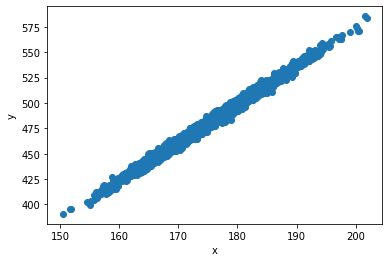

In [5]:

plt.plot(x_train_float , y_train_float , 'o')
plt.ylabel("y")
plt.xlabel("x")

In [6]:
x_max = np.amax(x_train_float)
y_max = np.amax(y_train_float)
x_train_float = x_train_float / x_max
y_train_float = y_train_float / y_max

print(x_max, y_max)

201.913788186 585.546772618


Text(0.5, 0, 'x')

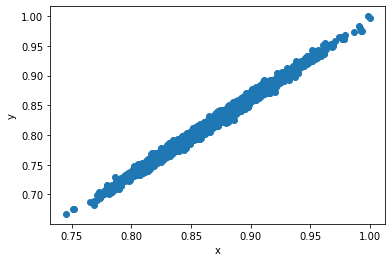

In [7]:

plt.plot(x_train_float , y_train_float , 'o')
plt.ylabel("y")
plt.xlabel("x")

## Network

epoch: 2, loss = 0.00642
epoch: 4, loss = 0.00179


Text(0, 0.5, 'Loss')

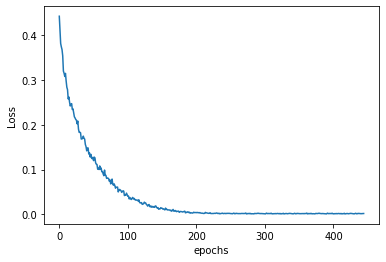

In [8]:
# 0) Prepare data

X = torch.from_numpy(np.array(x_train_float, dtype='float32'))
Y = torch.from_numpy(np.array(y_train_float, dtype='float32'))
y = Y.view((Y.shape[0], 1))
x  = X.view((X.shape[0], 1))

# 1) Model

input_size = 1
output_size = 1
#model = nn.Linear(input_size, output_size)

class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4 ,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
model = MyModelB()

# 2) Loss and optimizer
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  


# Batch Size 
Batch_size = 32
Datset_size= len(X)

iteration = Datset_size // Batch_size

# 3) Training loop
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    # Forward pass and loss

    for i in range(iteration):
        x_batch = x[i*Batch_size:i*Batch_size+ Batch_size]
        y_batch = y[i*Batch_size:i*Batch_size+ Batch_size]
        y_predicted = model(x_batch)
        loss = criterion(y_predicted, y_batch)
        losses.append(loss)

        # Backward pass and update
        loss.backward()
        optimizer.step()
        # zero grad before new step
        optimizer.zero_grad()
        #print('iteration_{}_loss_ {}'.format(i, loss))

    if (epoch+1) % 2 == 0:
            print(f'epoch: {epoch+1}, loss = {loss.item():.5f}')

plt.plot(range(num_epochs*iteration), losses)
plt.xlabel("epochs")
plt.ylabel("Loss")

## Evaluation


In [9]:
x_test = torch.from_numpy(np.array(x_test_float/x_max, dtype='float32'))
x_test = x_test.view(x_test.shape[0],1)

output = model.forward(x_test)
output *= y_max

total_loss = 0
for index, sample in enumerate(output):
    loss = abs(sample - y_test_float[index]) 
    #print(loss, sample, y_test_float[index])
    
    total_loss += loss
mean_absolute_error = total_loss / len(output)
print(mean_absolute_error / 10)


tensor([1.8443], grad_fn=<DivBackward0>)


## Saving Model

In [10]:
dirName = 'Trained_models'
PATH = 'Trained_models/height_upper_leg_{}'.format(mean_absolute_error.item())

if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")
        
torch.save(model.state_dict(), PATH)
#the_model = torch.load(PATH)

Directory  Trained_models  already exists


## Average Loss with Pre-calculated weight

In [11]:
state_dict = model.state_dict()
for name, param in state_dict.items():
    print(param.data)
    
#model.load_state_dict(state_dict)

tensor([[ 0.7930],
        [ 0.4274],
        [ 0.4385],
        [-0.2827]])
tensor([-0.9399,  0.7708, -0.7005, -0.9524])
tensor([[ 0.4232,  0.5955, -0.3015,  0.1392]])
tensor([0.1450])


In [12]:
x_test_float[0]

172.18176398623444

In [13]:
y_test_float[0]

466.65810795093006